In [ ]:
# 필요한 라이브러리 설치
!pip install gensim
from gensim import corpora, models
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models, matutils
from wordcloud import WordCloud

In [ ]:
# 엑셀 파일을 pandas DataFrame으로 읽어옵니다
data = pd.read_excel('ccs_raw.xlsx')

In [ ]:
# NaN 값을 제거하거나 특정 값으로 대체합니다
data['Abstract'].fillna('', inplace=True)
data['Claims'].fillna('', inplace=True)

# 데이터를 문자열로 변환
data['Abstract'] = data['Abstract'].astype(str)
data['Claims'] = data['Claims'].astype(str)

In [ ]:
# "publication date" 열에서 날짜 정보를 추출하여 리스트로 만듭니다
data['Publication Date'] = pd.to_datetime(data['Publication Date'], errors='coerce')

# 유효한 날짜 데이터만 남기고 NaN 값을 제거합니다
data = data.dropna(subset=['Publication Date'])

# "publication date" 열이 2022년 12월 31일 이전인 데이터만 필터링합니다
filtered_data = data[data['Publication Date'] <= '2022-12-31']

# 문장 쌍을 병합하여 하나의 텍스트로 만듭니다
docs = filtered_data['Abstract'] + ' ' + filtered_data['Claims']


In [ ]:
# docs: 텍스트 데이터 리스트 또는 배열

# 정규표현식으로 별 관련없는 단어들을 제거하기 위한 패턴 생성
stop_words_pattern = re.compile(r'\b(claim|according|second|formula|claims|method|said|subject|thereof|preferably|likelihood|group|comprising|comprises|sample|target|hours|value|optionally)\w*\b', flags=re.IGNORECASE)

# 텍스트 데이터에서 관련없는 단어를 제거하고, 나머지 단어로 구성된 리스트 생성
docs = [" ".join([word for word in re.split(r'\W+', doc) if not stop_words_pattern.match(word)]) for doc in docs]

# CountVectorizer를 사용하여 문서-단어 행렬 생성
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(docs)

In [ ]:
# CountVectorizer를 사용하여 문서-단어 행렬 생성
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(docs)

# gensim의 LDA 모델 생성
num_topics = 10  # 토픽 수를 조정하세요
corpus = matutils.Sparse2Corpus(X, documents_columns=False)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
lda_model = models.LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=num_topics,
                             passes=15,
                             random_state=42)


In [ ]:
# 토픽 모델링 결과 출력
for i, topic in lda_model.print_topics(num_topics=num_topics):
    print(f"Topic {i}: {topic}")

Topic 0: 0.021*"process" + 0.017*"solution" + 0.014*"water" + 0.014*"stream" + 0.012*"gas" + 0.012*"hydrogen" + 0.011*"acid" + 0.011*"carbon" + 0.010*"step" + 0.010*"liquid"
Topic 1: 0.030*"metal" + 0.023*"material" + 0.014*"layer" + 0.013*"oxide" + 0.013*"electrode" + 0.011*"substrate" + 0.008*"surface" + 0.008*"selected" + 0.008*"conductive" + 0.007*"device"
Topic 2: 0.028*"fuel" + 0.027*"power" + 0.026*"cell" + 0.019*"gas" + 0.015*"energy" + 0.014*"unit" + 0.012*"device" + 0.012*"control" + 0.011*"storage" + 0.010*"voltage"
Topic 3: 0.020*"electrolyte" + 0.019*"electrode" + 0.018*"compound" + 0.017*"battery" + 0.017*"lithium" + 0.014*"having" + 0.012*"carbon" + 0.011*"selected" + 0.011*"alkyl" + 0.011*"solution"
Topic 4: 0.034*"substituted" + 0.025*"atoms" + 0.021*"organic" + 0.019*"ring" + 0.019*"having" + 0.017*"aromatic" + 0.016*"selected" + 0.013*"independently" + 0.012*"molecule" + 0.011*"consisting"
Topic 5: 0.012*"id" + 0.012*"acid" + 0.011*"seq" + 0.011*"composition" + 0.008

In [ ]:
# 시각화
# WordCloud 시각화
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic}")
    plt.show()

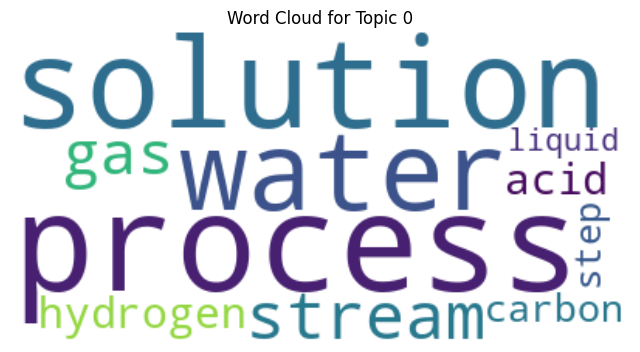

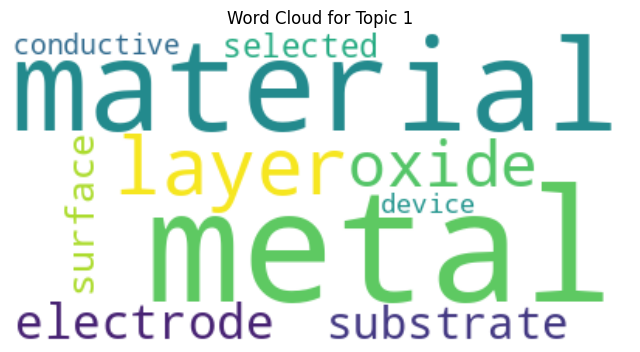

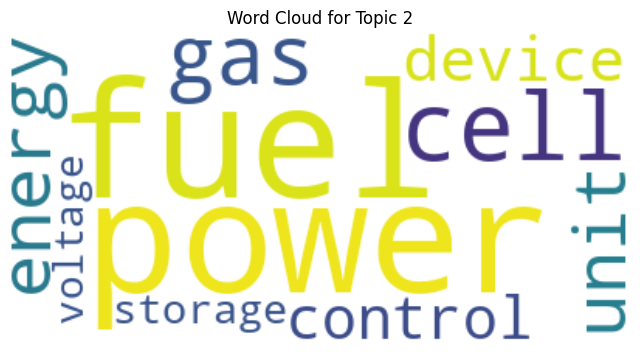

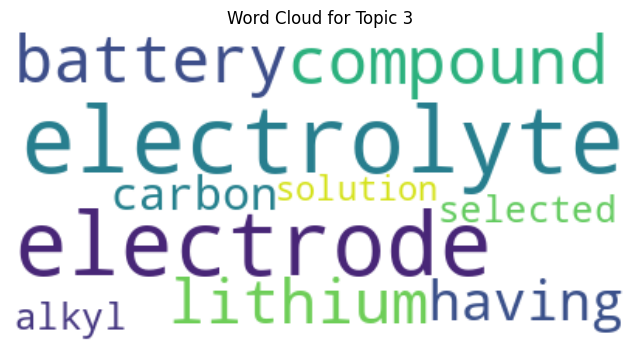

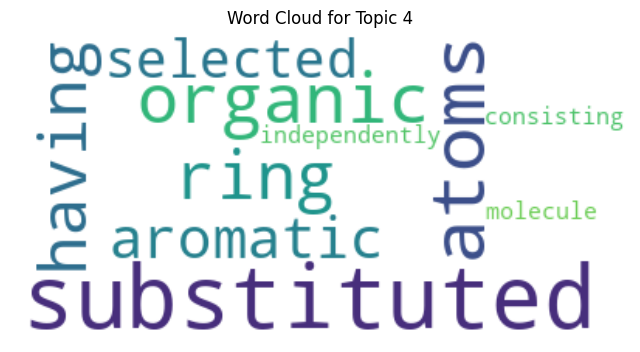

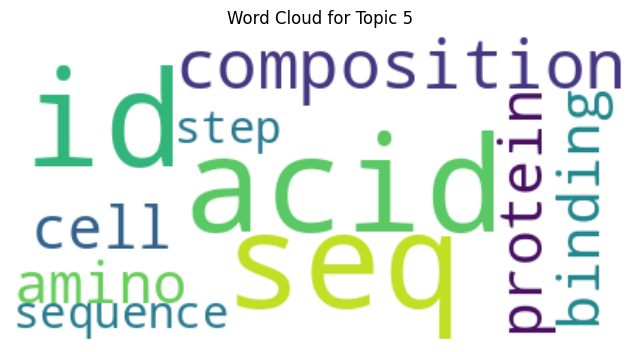

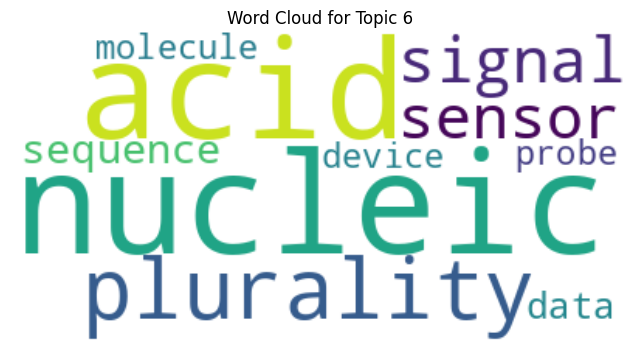

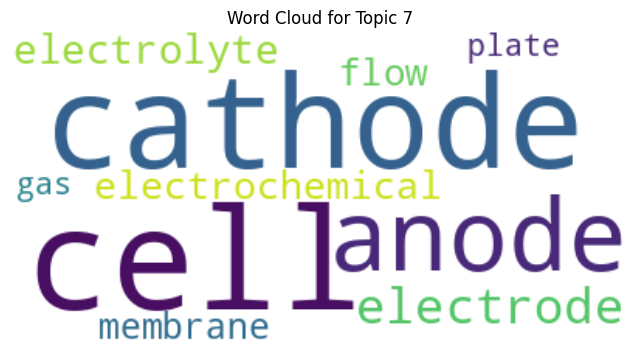

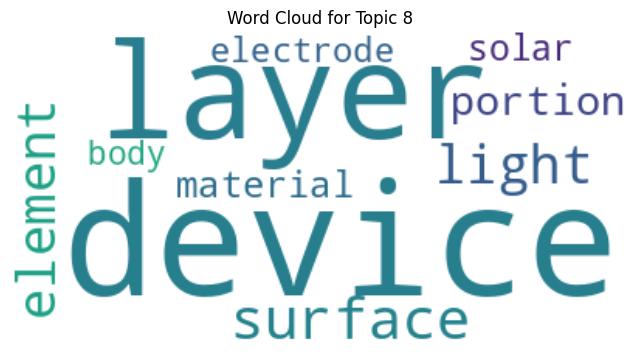

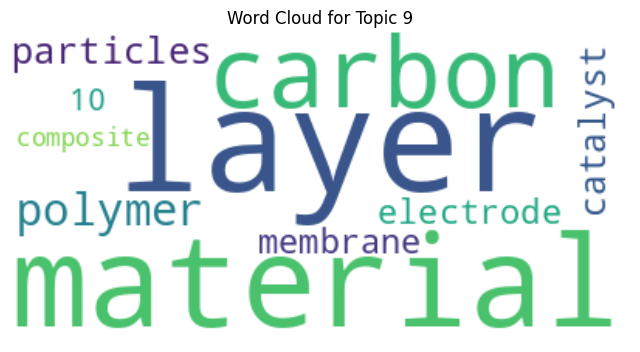

In [ ]:
# Show wordclouds for all topics
for topic in range(num_topics):
    create_wordcloud(lda_model, topic=topic)

In [ ]:
# 토픽 및 연도 시각화
# "publication date" 컬럼에서 연도 정보를 추출하여 리스트로 만듭니다
data['Publication Date'] = pd.to_datetime(data['Publication Date'])
filtered_data = data[data['Publication Date'] <= '2022-12-31']
years = filtered_data['Publication Date'].dt.year.tolist()


In [ ]:
# 토픽 및 연도를 묶어서 데이터프레임 생성
min_length = min(len(lda_model[corpus]), len(years))
topic_df = pd.DataFrame({'Topic': [max(topic, key=lambda x: x[1])[0] for topic in lda_model[corpus[:min_length]]], 'Year': years[:min_length]})


In [ ]:
# 연도별 토픽 분포를 계산합니다
topic_distribution_by_year = topic_df.groupby(['Year', 'Topic']).size().unstack(fill_value=0)


<Figure size 1500x2000 with 0 Axes>

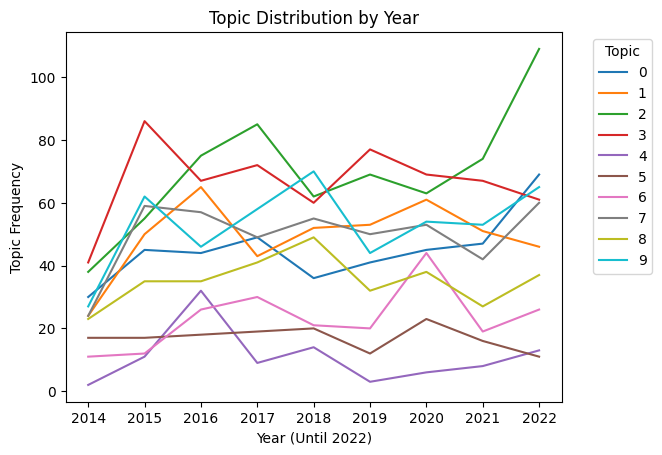

In [ ]:
# 시각화
plt.figure(figsize=(15, 20))
topic_distribution_by_year[topic_distribution_by_year.index <= 2022].plot(kind='line')
plt.xlabel('Year (Until 2022)')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution by Year')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()